In [1]:
import os
from typing import *

In [2]:
os.getcwd()
# Setting the baseline:
os.chdir('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP')


curPath: str = os.getcwd() + "/src/CausalNexStudy/"

dataPath: str = curPath + "data/student/"


print("curPath = ", curPath, "\n")
print("dataPath = ", dataPath, "\n")

curPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy/ 

dataPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy/data/student/ 



In [3]:
import sys
# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
# For being able to import files within CausalNex folder
sys.path.append(curPath)

sys.path

['/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python37.zip',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/lib-dynload',
 '',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/IPython/extensions',
 '/home/statisticallyfit/.ipython',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/utils/',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy/']

# 1/ Structure Learning
## Structure from Domain Knowledge
We can manually define a structure model by specifying the relationships between different features.
First we must create an empty structure model.

In [4]:
from causalnex.structure import StructureModel

structureModel: StructureModel = StructureModel()
structureModel

Next we can specify the relationships between features. Let us assume that experts tell us the following causal relationships are known (where G1 is grade in semester 1):

* `health` $\longrightarrow$ `absences`
* `health` $\longrightarrow$ `G1`

In [5]:
structureModel.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

## Visualizing the Structure

In [6]:
structureModel.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

In [7]:
structureModel.nodes

NodeView(('health', 'absences', 'G1'))

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'health', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


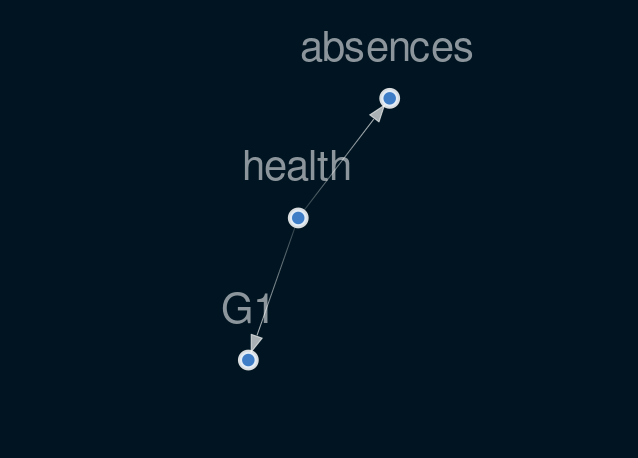

In [8]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    structureModel,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_first = curPath + "structure_model_first.png"

viz.draw(filename_first)
Image(filename_first)

## Learning the Structure
Can use CausalNex to learn structure model from data, when number of variables grows or domain knowledge does not exist. (Algorithm used is the [NOTEARS algorithm](https://arxiv.org/abs/1803.01422)).
* NOTE: not always necessary to train / test split because structure learning should be a joint effort between machine learning and domain experts.

First must pre-process the data so the [NOTEARS algorithm](https://arxiv.org/abs/1803.01422) can be used.

## Preparing the Data for Structure Learning

In [9]:
import pandas as pd
from pandas.core.frame import DataFrame

fileName: str = dataPath + 'student-por.csv'
data: DataFrame = pd.read_csv(fileName, delimiter = ';')

data.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,12,12,13


Can see the features are numeric and non-numeric. Can drop sensitive features like gender that we do not want to include in our model.

In [10]:
iDropCol: List[int] = ['school','sex','age','Mjob', 'Fjob','reason','guardian']

data = data.drop(columns = iDropCol)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


Next we want tomake our data numeric since this is what the NOTEARS algorithm expects. We can do this by label-encoding the non-numeric variables (to make them also numeric, like the current numeric variables).

In [11]:
import numpy as np


structData: DataFrame = data.copy()

# This operation below excludes all column variables that are number variables (so keeping only categorical variables)
structData.select_dtypes(exclude=[np.number]).head(5)

,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,U,GT3,A,yes,no,no,no,yes,yes,no,no
1,U,GT3,T,no,yes,no,no,no,yes,yes,no
2,U,LE3,T,yes,no,no,no,yes,yes,yes,no
3,U,GT3,T,no,yes,no,yes,yes,yes,yes,yes
4,U,GT3,T,no,yes,no,no,yes,yes,no,no


In [12]:
# Getting the names of the categorical variables (columns)
structData.select_dtypes(exclude=[np.number]).columns

Index(['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

In [13]:
namesOfCategoricalVars: List[str] = list(structData.select_dtypes(exclude=[np.number]).columns)
namesOfCategoricalVars

['address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [14]:
from sklearn.preprocessing import LabelEncoder

labelEncoder: LabelEncoder = LabelEncoder()

# NOTE: structData keeps also the numeric columns, doesn't exclude them! just updates the non-numeric cols.
for varName in namesOfCategoricalVars:
    structData[varName] = labelEncoder.fit_transform(y = structData[varName])

In [15]:
structData.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


In [16]:
# Going to compare the converted numeric values to their previous categorical values:
namesOfCategoricalVars

['address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [17]:
categData: DataFrame = data.select_dtypes(exclude=[np.number])

In [18]:
# The different values of Address variable (R and U)
np.unique(categData['address'])

array(['R', 'U'], dtype=object)

In [19]:
np.unique(categData['famsize'])

array(['GT3', 'LE3'], dtype=object)

In [20]:
np.unique(categData['Pstatus'])

array(['A', 'T'], dtype=object)

In [21]:
np.unique(categData['schoolsup'])

array(['no', 'yes'], dtype=object)

In [22]:
np.unique(categData['famsup'])

array(['no', 'yes'], dtype=object)

In [23]:
np.unique(categData['paid'])

array(['no', 'yes'], dtype=object)

In [24]:
np.unique(categData['activities'])

array(['no', 'yes'], dtype=object)

In [25]:
np.unique(categData['nursery'])

array(['no', 'yes'], dtype=object)

In [26]:
np.unique(categData['higher'])

array(['no', 'yes'], dtype=object)

In [27]:
np.unique(categData['internet'])

array(['no', 'yes'], dtype=object)

In [28]:
np.unique(categData['romantic'])

array(['no', 'yes'], dtype=object)

In [29]:
# A numeric column:
np.unique(data['Medu'])



array([0, 1, 2, 3, 4])

In [30]:
# All the values we convert in structData are binary, so testing how a non-binary one gets converted here:
testMultivals: List[str] = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

assert list(labelEncoder.fit_transform(y = testMultivals)) == [0, 1, 2, 3, 4, 5, 6, 7]

Now apply the NOTEARS algo to learn the structure:



In [31]:

#from src.utils.Clock import *

def clock(startTime, endTime):
    elapsedTime = endTime - startTime
    elapsedMins = int(elapsedTime / 60)
    elapsedSecs = int(elapsedTime - (elapsedMins * 60))
    return elapsedMins, elapsedSecs

In [32]:
from causalnex.structure.notears import from_pandas
import time

startTime: float = time.time()

structureModelLearned = from_pandas(X = structData)

print(f"Time taken = {clock(startTime = startTime, endTime = time.time())}")

Time taken = (6, 1)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'address', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


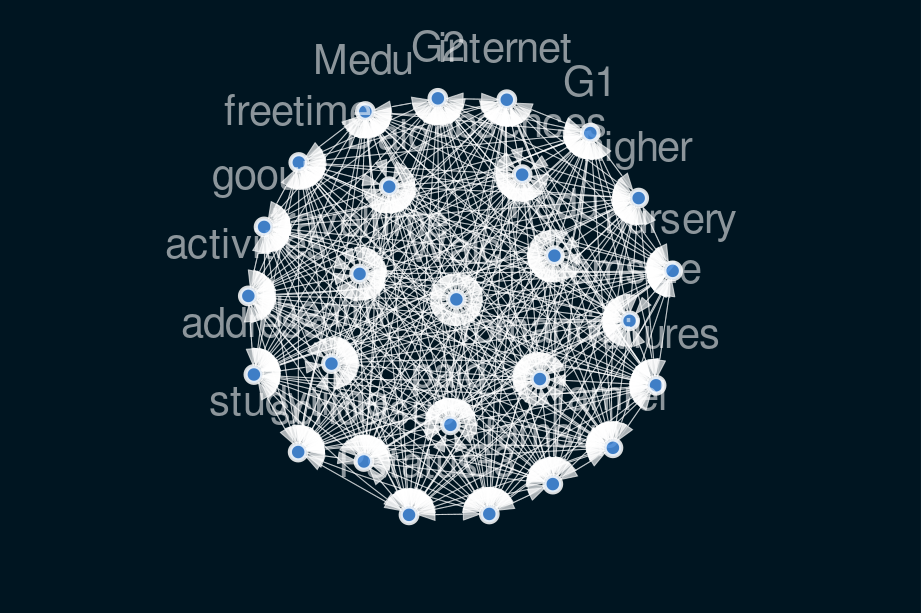

In [33]:
# Now visualize it:
viz = plot_structure(
    structureModelLearned,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_learned = curPath + "structure_model_learnedStructure.png"

viz.draw(filename_learned)
Image(filename_learned)





Can apply thresholding here to prune the algorithm's resulting fully connected graph. Thresholding can be applied either by specifying the value for the parameter `w_threshold` in `from_pandas` or we can remove the edges by calling the structure model function `remove_edges_below_threshold`.

In [34]:
structureModelPruned = structureModelLearned.copy()
structureModelPruned.remove_edges_below_threshold(threshold = 0.8)

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'address', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'address', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


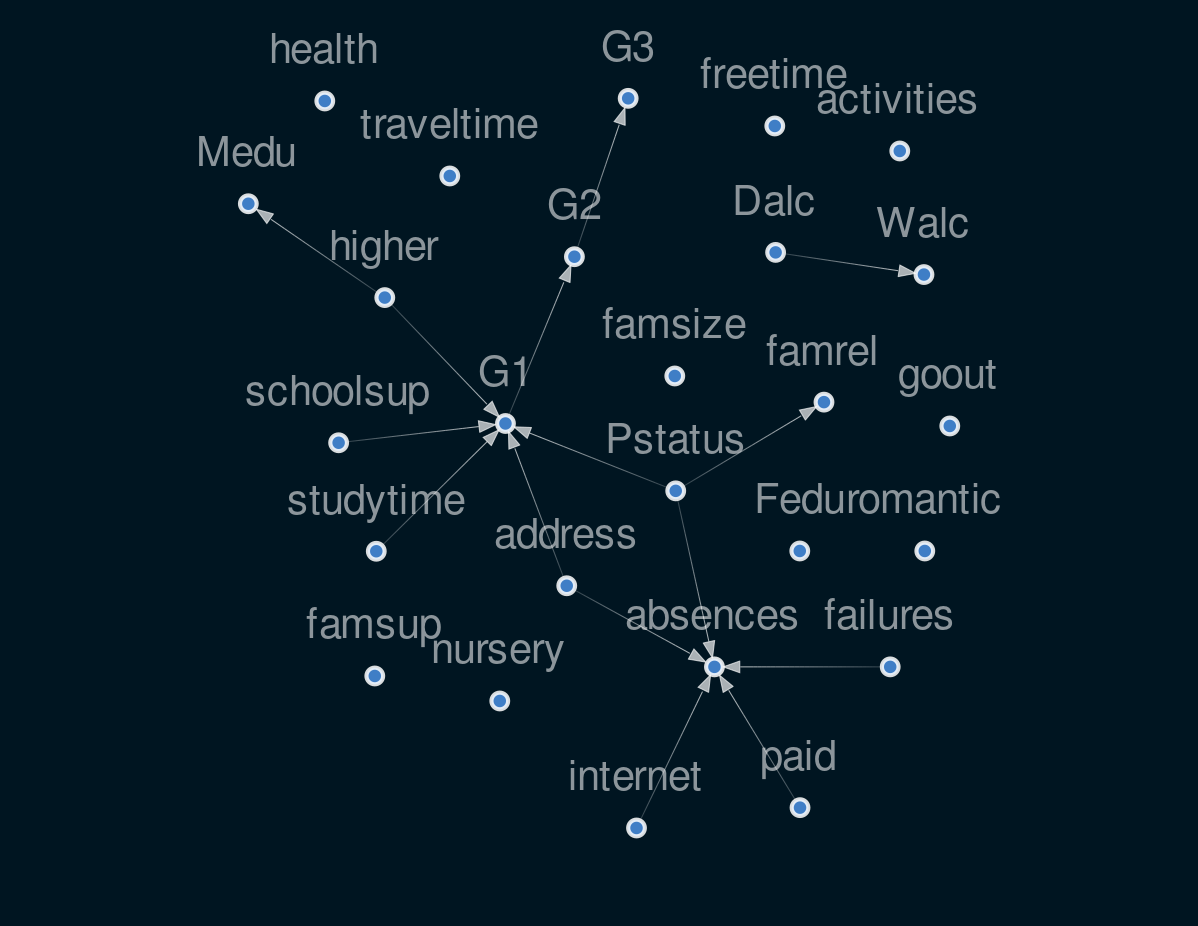

In [35]:
# Now visualize it:
viz = plot_structure(
    structureModelPruned,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_pruned = curPath + "structure_model_pruned.png"
viz.draw(filename_pruned)
Image(filename_pruned)

Comparing the freshly learned model with the pruned model:

In [36]:
structureModelLearned.adj

AdjacencyView({'address': {'famsize': {'origin': 'learned', 'weight': 0.07172400411745194}, 'Pstatus': {'origin': 'learned', 'weight': 0.027500652131841753}, 'Medu': {'origin': 'learned', 'weight': 0.4329609981782503}, 'Fedu': {'origin': 'learned', 'weight': 0.10940724573937048}, 'traveltime': {'origin': 'learned', 'weight': -0.3080468648891065}, 'studytime': {'origin': 'learned', 'weight': 0.22858517407180592}, 'failures': {'origin': 'learned', 'weight': 0.06633709792506814}, 'schoolsup': {'origin': 'learned', 'weight': 2.265558640319601e-06}, 'famsup': {'origin': 'learned', 'weight': 4.164128335492464e-06}, 'paid': {'origin': 'learned', 'weight': 2.6188325902813357e-06}, 'activities': {'origin': 'learned', 'weight': 8.921883360997223e-06}, 'nursery': {'origin': 'learned', 'weight': 1.0431757754516237e-06}, 'higher': {'origin': 'learned', 'weight': 0.2175470691398659}, 'internet': {'origin': 'learned', 'weight': 4.631899217412905e-07}, 'romantic': {'origin': 'learned', 'weight': 2.116

In [37]:
structureModelPruned.adj

AdjacencyView({'address': {'absences': {'origin': 'learned', 'weight': 1.0400949529066366}, 'G1': {'origin': 'learned', 'weight': 1.006295091882122}}, 'famsize': {}, 'Pstatus': {'famrel': {'origin': 'learned', 'weight': 0.8402877660070628}, 'absences': {'origin': 'learned', 'weight': -1.0538754156321408}, 'G1': {'origin': 'learned', 'weight': 1.261362346111696}}, 'Medu': {}, 'Fedu': {}, 'traveltime': {}, 'studytime': {'G1': {'origin': 'learned', 'weight': 0.8636139137063454}}, 'failures': {'absences': {'origin': 'learned', 'weight': 0.9395791571697139}}, 'schoolsup': {'G1': {'origin': 'learned', 'weight': -0.8015184747758134}}, 'famsup': {}, 'paid': {'absences': {'origin': 'learned', 'weight': -1.0534625350951718}}, 'activities': {}, 'nursery': {}, 'higher': {'Medu': {'origin': 'learned', 'weight': 0.9842407795725915}, 'G1': {'origin': 'learned', 'weight': 2.6906165356962597}}, 'internet': {'absences': {'origin': 'learned', 'weight': 0.8369080746968736}}, 'romantic': {}, 'famrel': {}, 

In [38]:
structureModelLearned.degree

DiDegreeView({'address': 50, 'famsize': 50, 'Pstatus': 50, 'Medu': 50, 'Fedu': 50, 'traveltime': 50, 'studytime': 50, 'failures': 50, 'schoolsup': 50, 'famsup': 50, 'paid': 50, 'activities': 50, 'nursery': 50, 'higher': 50, 'internet': 50, 'romantic': 50, 'famrel': 50, 'freetime': 50, 'goout': 50, 'Dalc': 50, 'Walc': 50, 'health': 50, 'absences': 50, 'G1': 50, 'G2': 50, 'G3': 50})

In [39]:
structureModelPruned.degree

DiDegreeView({'address': 2, 'famsize': 0, 'Pstatus': 3, 'Medu': 1, 'Fedu': 0, 'traveltime': 0, 'studytime': 1, 'failures': 1, 'schoolsup': 1, 'famsup': 0, 'paid': 1, 'activities': 0, 'nursery': 0, 'higher': 2, 'internet': 1, 'romantic': 0, 'famrel': 1, 'freetime': 0, 'goout': 0, 'Dalc': 1, 'Walc': 1, 'health': 0, 'absences': 5, 'G1': 6, 'G2': 2, 'G3': 1})

In [40]:
structureModelLearned.edges

OutEdgeView([('address', 'famsize'), ('address', 'Pstatus'), ('address', 'Medu'), ('address', 'Fedu'), ('address', 'traveltime'), ('address', 'studytime'), ('address', 'failures'), ('address', 'schoolsup'), ('address', 'famsup'), ('address', 'paid'), ('address', 'activities'), ('address', 'nursery'), ('address', 'higher'), ('address', 'internet'), ('address', 'romantic'), ('address', 'famrel'), ('address', 'freetime'), ('address', 'goout'), ('address', 'Dalc'), ('address', 'Walc'), ('address', 'health'), ('address', 'absences'), ('address', 'G1'), ('address', 'G2'), ('address', 'G3'), ('famsize', 'address'), ('famsize', 'Pstatus'), ('famsize', 'Medu'), ('famsize', 'Fedu'), ('famsize', 'traveltime'), ('famsize', 'studytime'), ('famsize', 'failures'), ('famsize', 'schoolsup'), ('famsize', 'famsup'), ('famsize', 'paid'), ('famsize', 'activities'), ('famsize', 'nursery'), ('famsize', 'higher'), ('famsize', 'internet'), ('famsize', 'romantic'), ('famsize', 'famrel'), ('famsize', 'freetime')

In [41]:
structureModelPruned.edges

OutEdgeView([('address', 'absences'), ('address', 'G1'), ('Pstatus', 'famrel'), ('Pstatus', 'absences'), ('Pstatus', 'G1'), ('studytime', 'G1'), ('failures', 'absences'), ('schoolsup', 'G1'), ('paid', 'absences'), ('higher', 'Medu'), ('higher', 'G1'), ('internet', 'absences'), ('Dalc', 'Walc'), ('G1', 'G2'), ('G2', 'G3')])

In [42]:
structureModelLearned.in_degree

InDegreeView({'address': 25, 'famsize': 25, 'Pstatus': 25, 'Medu': 25, 'Fedu': 25, 'traveltime': 25, 'studytime': 25, 'failures': 25, 'schoolsup': 25, 'famsup': 25, 'paid': 25, 'activities': 25, 'nursery': 25, 'higher': 25, 'internet': 25, 'romantic': 25, 'famrel': 25, 'freetime': 25, 'goout': 25, 'Dalc': 25, 'Walc': 25, 'health': 25, 'absences': 25, 'G1': 25, 'G2': 25, 'G3': 25})

In [43]:
structureModelPruned.in_degree

InDegreeView({'address': 0, 'famsize': 0, 'Pstatus': 0, 'Medu': 1, 'Fedu': 0, 'traveltime': 0, 'studytime': 0, 'failures': 0, 'schoolsup': 0, 'famsup': 0, 'paid': 0, 'activities': 0, 'nursery': 0, 'higher': 0, 'internet': 0, 'romantic': 0, 'famrel': 1, 'freetime': 0, 'goout': 0, 'Dalc': 0, 'Walc': 1, 'health': 0, 'absences': 5, 'G1': 5, 'G2': 1, 'G3': 1})

In [44]:
structureModelLearned.in_edges

InEdgeView([('famsize', 'address'), ('Pstatus', 'address'), ('Medu', 'address'), ('Fedu', 'address'), ('traveltime', 'address'), ('studytime', 'address'), ('failures', 'address'), ('schoolsup', 'address'), ('famsup', 'address'), ('paid', 'address'), ('activities', 'address'), ('nursery', 'address'), ('higher', 'address'), ('internet', 'address'), ('romantic', 'address'), ('famrel', 'address'), ('freetime', 'address'), ('goout', 'address'), ('Dalc', 'address'), ('Walc', 'address'), ('health', 'address'), ('absences', 'address'), ('G1', 'address'), ('G2', 'address'), ('G3', 'address'), ('address', 'famsize'), ('Pstatus', 'famsize'), ('Medu', 'famsize'), ('Fedu', 'famsize'), ('traveltime', 'famsize'), ('studytime', 'famsize'), ('failures', 'famsize'), ('schoolsup', 'famsize'), ('famsup', 'famsize'), ('paid', 'famsize'), ('activities', 'famsize'), ('nursery', 'famsize'), ('higher', 'famsize'), ('internet', 'famsize'), ('romantic', 'famsize'), ('famrel', 'famsize'), ('freetime', 'famsize'),

In [45]:
structureModelPruned.in_edges

InEdgeView([('higher', 'Medu'), ('Pstatus', 'famrel'), ('Dalc', 'Walc'), ('address', 'absences'), ('Pstatus', 'absences'), ('failures', 'absences'), ('paid', 'absences'), ('internet', 'absences'), ('address', 'G1'), ('Pstatus', 'G1'), ('studytime', 'G1'), ('schoolsup', 'G1'), ('higher', 'G1'), ('G1', 'G2'), ('G2', 'G3')])

In [46]:
structureModelLearned.number_of_nodes()

26

In [47]:
structureModelPruned.number_of_nodes()

26

In [48]:
structureModelLearned.node

NodeView(('address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3'))

In [49]:
structureModelPruned.node

NodeView(('address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3'))

In [50]:
assert structureModelLearned.node == structureModelLearned.nodes

structureModelLearned.nodes

NodeView(('address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3'))

In [51]:
assert structureModelPruned.node == structureModelPruned.nodes

structureModelPruned.nodes

NodeView(('address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3'))

In [52]:
structureModelLearned.out_degree

OutDegreeView({'address': 25, 'famsize': 25, 'Pstatus': 25, 'Medu': 25, 'Fedu': 25, 'traveltime': 25, 'studytime': 25, 'failures': 25, 'schoolsup': 25, 'famsup': 25, 'paid': 25, 'activities': 25, 'nursery': 25, 'higher': 25, 'internet': 25, 'romantic': 25, 'famrel': 25, 'freetime': 25, 'goout': 25, 'Dalc': 25, 'Walc': 25, 'health': 25, 'absences': 25, 'G1': 25, 'G2': 25, 'G3': 25})

In [53]:
structureModelPruned.out_degree

OutDegreeView({'address': 2, 'famsize': 0, 'Pstatus': 3, 'Medu': 0, 'Fedu': 0, 'traveltime': 0, 'studytime': 1, 'failures': 1, 'schoolsup': 1, 'famsup': 0, 'paid': 1, 'activities': 0, 'nursery': 0, 'higher': 2, 'internet': 1, 'romantic': 0, 'famrel': 0, 'freetime': 0, 'goout': 0, 'Dalc': 1, 'Walc': 0, 'health': 0, 'absences': 0, 'G1': 1, 'G2': 1, 'G3': 0})

In [54]:
structureModelLearned.out_edges

OutEdgeView([('address', 'famsize'), ('address', 'Pstatus'), ('address', 'Medu'), ('address', 'Fedu'), ('address', 'traveltime'), ('address', 'studytime'), ('address', 'failures'), ('address', 'schoolsup'), ('address', 'famsup'), ('address', 'paid'), ('address', 'activities'), ('address', 'nursery'), ('address', 'higher'), ('address', 'internet'), ('address', 'romantic'), ('address', 'famrel'), ('address', 'freetime'), ('address', 'goout'), ('address', 'Dalc'), ('address', 'Walc'), ('address', 'health'), ('address', 'absences'), ('address', 'G1'), ('address', 'G2'), ('address', 'G3'), ('famsize', 'address'), ('famsize', 'Pstatus'), ('famsize', 'Medu'), ('famsize', 'Fedu'), ('famsize', 'traveltime'), ('famsize', 'studytime'), ('famsize', 'failures'), ('famsize', 'schoolsup'), ('famsize', 'famsup'), ('famsize', 'paid'), ('famsize', 'activities'), ('famsize', 'nursery'), ('famsize', 'higher'), ('famsize', 'internet'), ('famsize', 'romantic'), ('famsize', 'famrel'), ('famsize', 'freetime')

In [55]:
structureModelPruned.out_edges

OutEdgeView([('address', 'absences'), ('address', 'G1'), ('Pstatus', 'famrel'), ('Pstatus', 'absences'), ('Pstatus', 'G1'), ('studytime', 'G1'), ('failures', 'absences'), ('schoolsup', 'G1'), ('paid', 'absences'), ('higher', 'Medu'), ('higher', 'G1'), ('internet', 'absences'), ('Dalc', 'Walc'), ('G1', 'G2'), ('G2', 'G3')])

In [56]:
# Adjacency object holding predecessors of each node
structureModelLearned.pred

AdjacencyView({'address': {'famsize': {'origin': 'learned', 'weight': 2.57364988344861e-06}, 'Pstatus': {'origin': 'learned', 'weight': 4.034341252476512e-06}, 'Medu': {'origin': 'learned', 'weight': 5.282843496249485e-07}, 'Fedu': {'origin': 'learned', 'weight': 1.815837863695999e-06}, 'traveltime': {'origin': 'learned', 'weight': -3.2083752911421134e-08}, 'studytime': {'origin': 'learned', 'weight': 1.2094798742837836e-06}, 'failures': {'origin': 'learned', 'weight': 1.0270730806788747e-06}, 'schoolsup': {'origin': 'learned', 'weight': 0.09016610695015827}, 'famsup': {'origin': 'learned', 'weight': 0.10427386381413724}, 'paid': {'origin': 'learned', 'weight': -0.06226780216318523}, 'activities': {'origin': 'learned', 'weight': 0.05553758017558176}, 'nursery': {'origin': 'learned', 'weight': 0.2776178205344719}, 'higher': {'origin': 'learned', 'weight': 7.851783367975633e-07}, 'internet': {'origin': 'learned', 'weight': 0.40328532019811464}, 'romantic': {'origin': 'learned', 'weight':

In [57]:
# Adjacency object holding predecessors of each node
structureModelPruned.pred

AdjacencyView({'address': {}, 'famsize': {}, 'Pstatus': {}, 'Medu': {'higher': {'origin': 'learned', 'weight': 0.9842407795725915}}, 'Fedu': {}, 'traveltime': {}, 'studytime': {}, 'failures': {}, 'schoolsup': {}, 'famsup': {}, 'paid': {}, 'activities': {}, 'nursery': {}, 'higher': {}, 'internet': {}, 'romantic': {}, 'famrel': {'Pstatus': {'origin': 'learned', 'weight': 0.8402877660070628}}, 'freetime': {}, 'goout': {}, 'Dalc': {}, 'Walc': {'Dalc': {'origin': 'learned', 'weight': 0.8623769618608512}}, 'health': {}, 'absences': {'address': {'origin': 'learned', 'weight': 1.0400949529066366}, 'Pstatus': {'origin': 'learned', 'weight': -1.0538754156321408}, 'failures': {'origin': 'learned', 'weight': 0.9395791571697139}, 'paid': {'origin': 'learned', 'weight': -1.0534625350951718}, 'internet': {'origin': 'learned', 'weight': 0.8369080746968736}}, 'G1': {'address': {'origin': 'learned', 'weight': 1.006295091882122}, 'Pstatus': {'origin': 'learned', 'weight': 1.261362346111696}, 'studytime':

In [58]:
# Adjacency object holding the successors of each node
structureModelLearned.succ

AdjacencyView({'address': {'famsize': {'origin': 'learned', 'weight': 0.07172400411745194}, 'Pstatus': {'origin': 'learned', 'weight': 0.027500652131841753}, 'Medu': {'origin': 'learned', 'weight': 0.4329609981782503}, 'Fedu': {'origin': 'learned', 'weight': 0.10940724573937048}, 'traveltime': {'origin': 'learned', 'weight': -0.3080468648891065}, 'studytime': {'origin': 'learned', 'weight': 0.22858517407180592}, 'failures': {'origin': 'learned', 'weight': 0.06633709792506814}, 'schoolsup': {'origin': 'learned', 'weight': 2.265558640319601e-06}, 'famsup': {'origin': 'learned', 'weight': 4.164128335492464e-06}, 'paid': {'origin': 'learned', 'weight': 2.6188325902813357e-06}, 'activities': {'origin': 'learned', 'weight': 8.921883360997223e-06}, 'nursery': {'origin': 'learned', 'weight': 1.0431757754516237e-06}, 'higher': {'origin': 'learned', 'weight': 0.2175470691398659}, 'internet': {'origin': 'learned', 'weight': 4.631899217412905e-07}, 'romantic': {'origin': 'learned', 'weight': 2.116

In [59]:
# Adjacency object holding the successors of each node
structureModelPruned.succ

AdjacencyView({'address': {'absences': {'origin': 'learned', 'weight': 1.0400949529066366}, 'G1': {'origin': 'learned', 'weight': 1.006295091882122}}, 'famsize': {}, 'Pstatus': {'famrel': {'origin': 'learned', 'weight': 0.8402877660070628}, 'absences': {'origin': 'learned', 'weight': -1.0538754156321408}, 'G1': {'origin': 'learned', 'weight': 1.261362346111696}}, 'Medu': {}, 'Fedu': {}, 'traveltime': {}, 'studytime': {'G1': {'origin': 'learned', 'weight': 0.8636139137063454}}, 'failures': {'absences': {'origin': 'learned', 'weight': 0.9395791571697139}}, 'schoolsup': {'G1': {'origin': 'learned', 'weight': -0.8015184747758134}}, 'famsup': {}, 'paid': {'absences': {'origin': 'learned', 'weight': -1.0534625350951718}}, 'activities': {}, 'nursery': {}, 'higher': {'Medu': {'origin': 'learned', 'weight': 0.9842407795725915}, 'G1': {'origin': 'learned', 'weight': 2.6906165356962597}}, 'internet': {'absences': {'origin': 'learned', 'weight': 0.8369080746968736}}, 'romantic': {}, 'famrel': {}, 

In [60]:
structureModelLearned.has_edge(u = 'Fedu', v= 'famsup')

True

In [61]:
structureModelPruned.has_edge(u = 'Fedu', v= 'famsup')

False

In [62]:
structureModelLearned.has_edge(u = 'address', v= 'absences')

True

In [63]:
structureModelPruned.has_edge(u = 'address', v= 'absences')

True

In [64]:
structureModelLearned.get_edge_data(u = 'address', v= 'absences')

{'origin': 'learned', 'weight': 1.0400949529066366}

In [65]:
# NOTE: after pruning the weight doesn't change
structureModelPruned.get_edge_data(u = 'address', v= 'absences')

{'origin': 'learned', 'weight': 1.0400949529066366}

In [66]:
list(structureModelLearned.neighbors(n = 'address'))

['famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2',
 'G3']

In [67]:
list(structureModelPruned.neighbors(n = 'address'))

['absences', 'G1']

In [68]:
# TODO: what does negative weight mean?
# TODO: why are weights not probabilities?
list(structureModelLearned.adjacency())[:2]

[('address',
  {'famsize': {'origin': 'learned', 'weight': 0.07172400411745194},
   'Pstatus': {'origin': 'learned', 'weight': 0.027500652131841753},
   'Medu': {'origin': 'learned', 'weight': 0.4329609981782503},
   'Fedu': {'origin': 'learned', 'weight': 0.10940724573937048},
   'traveltime': {'origin': 'learned', 'weight': -0.3080468648891065},
   'studytime': {'origin': 'learned', 'weight': 0.22858517407180592},
   'failures': {'origin': 'learned', 'weight': 0.06633709792506814},
   'schoolsup': {'origin': 'learned', 'weight': 2.265558640319601e-06},
   'famsup': {'origin': 'learned', 'weight': 4.164128335492464e-06},
   'paid': {'origin': 'learned', 'weight': 2.6188325902813357e-06},
   'activities': {'origin': 'learned', 'weight': 8.921883360997223e-06},
   'nursery': {'origin': 'learned', 'weight': 1.0431757754516237e-06},
   'higher': {'origin': 'learned', 'weight': 0.2175470691398659},
   'internet': {'origin': 'learned', 'weight': 4.631899217412905e-07},
   'romantic': {'orig

In [69]:
# TODO: what does negative weight mean?
# TODO: why are weights not probabilities?
list(structureModelPruned.adjacency())

[('address',
  {'absences': {'origin': 'learned', 'weight': 1.0400949529066366},
   'G1': {'origin': 'learned', 'weight': 1.006295091882122}}),
 ('famsize', {}),
 ('Pstatus',
  {'famrel': {'origin': 'learned', 'weight': 0.8402877660070628},
   'absences': {'origin': 'learned', 'weight': -1.0538754156321408},
   'G1': {'origin': 'learned', 'weight': 1.261362346111696}}),
 ('Medu', {}),
 ('Fedu', {}),
 ('traveltime', {}),
 ('studytime', {'G1': {'origin': 'learned', 'weight': 0.8636139137063454}}),
 ('failures',
  {'absences': {'origin': 'learned', 'weight': 0.9395791571697139}}),
 ('schoolsup', {'G1': {'origin': 'learned', 'weight': -0.8015184747758134}}),
 ('famsup', {}),
 ('paid', {'absences': {'origin': 'learned', 'weight': -1.0534625350951718}}),
 ('activities', {}),
 ('nursery', {}),
 ('higher',
  {'Medu': {'origin': 'learned', 'weight': 0.9842407795725915},
   'G1': {'origin': 'learned', 'weight': 2.6906165356962597}}),
 ('internet',
  {'absences': {'origin': 'learned', 'weight': 0

In [70]:
structureModelLearned.get_edge_data(u = 'address', v = 'G1') # something!

{'origin': 'learned', 'weight': 1.006295091882122}

In [71]:
structureModelPruned.get_edge_data(u = 'address', v = 'G1') # something!

{'origin': 'learned', 'weight': 1.006295091882122}

In [72]:
structureModelLearned.get_edge_data(u = 'Feduromantic', v = 'absences') # nothing!

In [73]:
structureModelPruned.get_edge_data(u = 'Feduromantic', v = 'absences') # nothing!

In [74]:
list(structureModelLearned.get_target_subgraph(node = 'absences').adjacency())[:2]

[('address',
  {'famsize': {'origin': 'learned', 'weight': 0.07172400411745194},
   'Pstatus': {'origin': 'learned', 'weight': 0.027500652131841753},
   'Medu': {'origin': 'learned', 'weight': 0.4329609981782503},
   'Fedu': {'origin': 'learned', 'weight': 0.10940724573937048},
   'traveltime': {'origin': 'learned', 'weight': -0.3080468648891065},
   'studytime': {'origin': 'learned', 'weight': 0.22858517407180592},
   'failures': {'origin': 'learned', 'weight': 0.06633709792506814},
   'schoolsup': {'origin': 'learned', 'weight': 2.265558640319601e-06},
   'famsup': {'origin': 'learned', 'weight': 4.164128335492464e-06},
   'paid': {'origin': 'learned', 'weight': 2.6188325902813357e-06},
   'activities': {'origin': 'learned', 'weight': 8.921883360997223e-06},
   'nursery': {'origin': 'learned', 'weight': 1.0431757754516237e-06},
   'higher': {'origin': 'learned', 'weight': 0.2175470691398659},
   'internet': {'origin': 'learned', 'weight': 4.631899217412905e-07},
   'romantic': {'orig

In [75]:
list(structureModelPruned.get_target_subgraph(node = 'absences').adjacency())




[('address',
  {'absences': {'origin': 'learned', 'weight': 1.0400949529066366},
   'G1': {'origin': 'learned', 'weight': 1.006295091882122}}),
 ('Pstatus',
  {'famrel': {'origin': 'learned', 'weight': 0.8402877660070628},
   'absences': {'origin': 'learned', 'weight': -1.0538754156321408},
   'G1': {'origin': 'learned', 'weight': 1.261362346111696}}),
 ('Medu', {}),
 ('studytime', {'G1': {'origin': 'learned', 'weight': 0.8636139137063454}}),
 ('failures',
  {'absences': {'origin': 'learned', 'weight': 0.9395791571697139}}),
 ('schoolsup', {'G1': {'origin': 'learned', 'weight': -0.8015184747758134}}),
 ('paid', {'absences': {'origin': 'learned', 'weight': -1.0534625350951718}}),
 ('higher',
  {'Medu': {'origin': 'learned', 'weight': 0.9842407795725915},
   'G1': {'origin': 'learned', 'weight': 2.6906165356962597}}),
 ('internet',
  {'absences': {'origin': 'learned', 'weight': 0.8369080746968736}}),
 ('famrel', {}),
 ('absences', {}),
 ('G1', {'G2': {'origin': 'learned', 'weight': 0.889

In the above structure some relations appear intuitively correct:
* `Pstatus` affects `famrel` - if parents live apart, the quality of family relationship may be poor as a result
* `internet` affects `absences` - the presence of internet at home may cause stduents to skip class.
* `studytime` affects `G1` - longer studytime should have a positive effect on a student's grade in semester 1 (`G1`).

However there are some relations that are certainly incorrect:
* `higher` affects `Medu` (Mother's education) - this relationship does not make sense as students who want to pursue higher education does not affect mother's education. It could be the OTHER WAY AROUND.

To avoid these erroneous relationships we can re-run the structure learning with some added constraints. Using the method `from_pandas` from `causalnex.structure.notears` to set the argument `tabu_edges`, with the edge (from --> to) which we do not want to include in the graph.

In [76]:

# Reruns the analysis from the structure data, just not including this edge.
# NOT modifying the previous `structureModel`.
structureModel: StructureModel = from_pandas(structData, tabu_edges=[("higher", "Medu")], w_threshold=0.8)

Now the `higher --> Medu` relationship is **no longer** in the graph.

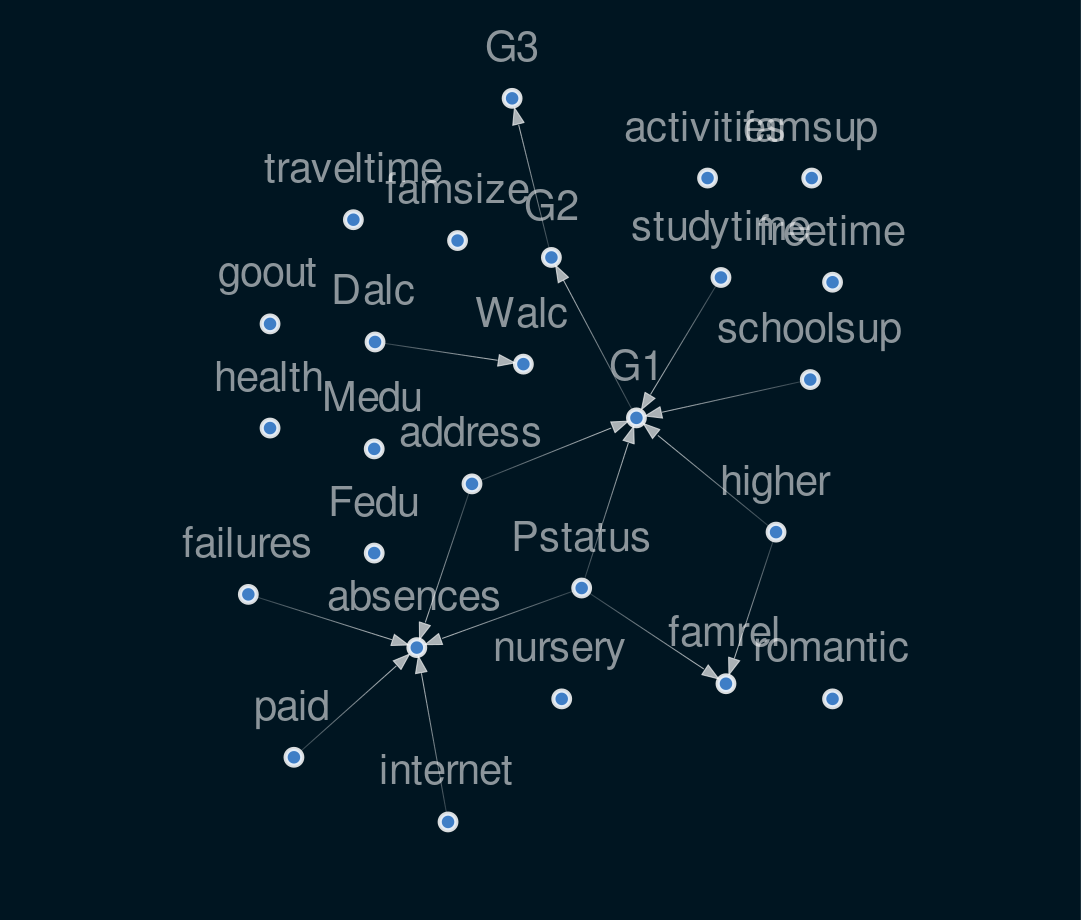

In [77]:
# Now visualize it:
viz = plot_structure(
    structureModel,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_noHigherMedu = curPath + "structure_model_learnedStructure_noHigherMedu.png"
viz.draw(filename_noHigherMedu)
Image(filename_noHigherMedu)

## Modifying the Structure (after structure learning)
To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. We can modify the structure model through adding and deleting the edges. For example we can add and remove edges with the function `add_edge(u_of_edges, v_of_edges)` that adds a causal relationship from `u` to `v`, where
* `u_of_edge` = causal node
* `v_of_edge` = effect node

and if the relation doesn't exist it will be created.

In [78]:
# NOTE the learning of the graph is different each time so these assertions may not be true all the time!
assert not structureModel.has_edge(u = 'higher', v = 'Medu')

# Adding causal relationship from health to paid (used to failures -> G1 ??)
structModeTestEdges = structureModel.copy()

# No edge, showing creation effect
assert not structModeTestEdges.has_edge(u ='health', v ='paid')
structModeTestEdges.add_edge(u_of_edge ='health', v_of_edge ='paid')
assert structModeTestEdges.has_edge(u ='health', v ='paid')
assert {'origin': 'unknown'} == structModeTestEdges.get_edge_data(u ='health', v ='paid')

In [79]:
# Has edge, showing replacement effect
assert structModeTestEdges.has_edge(u ='higher', v ='G1')
prevEdge = structModeTestEdges.get_edge_data(u ='higher', v ='G1')
prevEdge

{'origin': 'learned', 'weight': 2.7243556829495947}

In [80]:
structModeTestEdges.add_edge(u_of_edge ='higher', v_of_edge ='G1')
assert structModeTestEdges.has_edge(u ='higher', v ='G1')
curEdge = structModeTestEdges.get_edge_data(u ='higher', v ='G1')
curEdge
assert prevEdge == curEdge

In [81]:
# Has edge, showing removal effect
assert structModeTestEdges.has_edge(u ='higher', v ='famrel')
structModeTestEdges.get_edge_data(u ='higher', v ='famrel')

{'origin': 'learned', 'weight': 0.8896329694730597}

In [82]:
structModeTestEdges.remove_edge(u ='higher', v ='famrel')
assert not structModeTestEdges.has_edge(u ='higher', v ='famrel')

Can now visualize the updated structure:

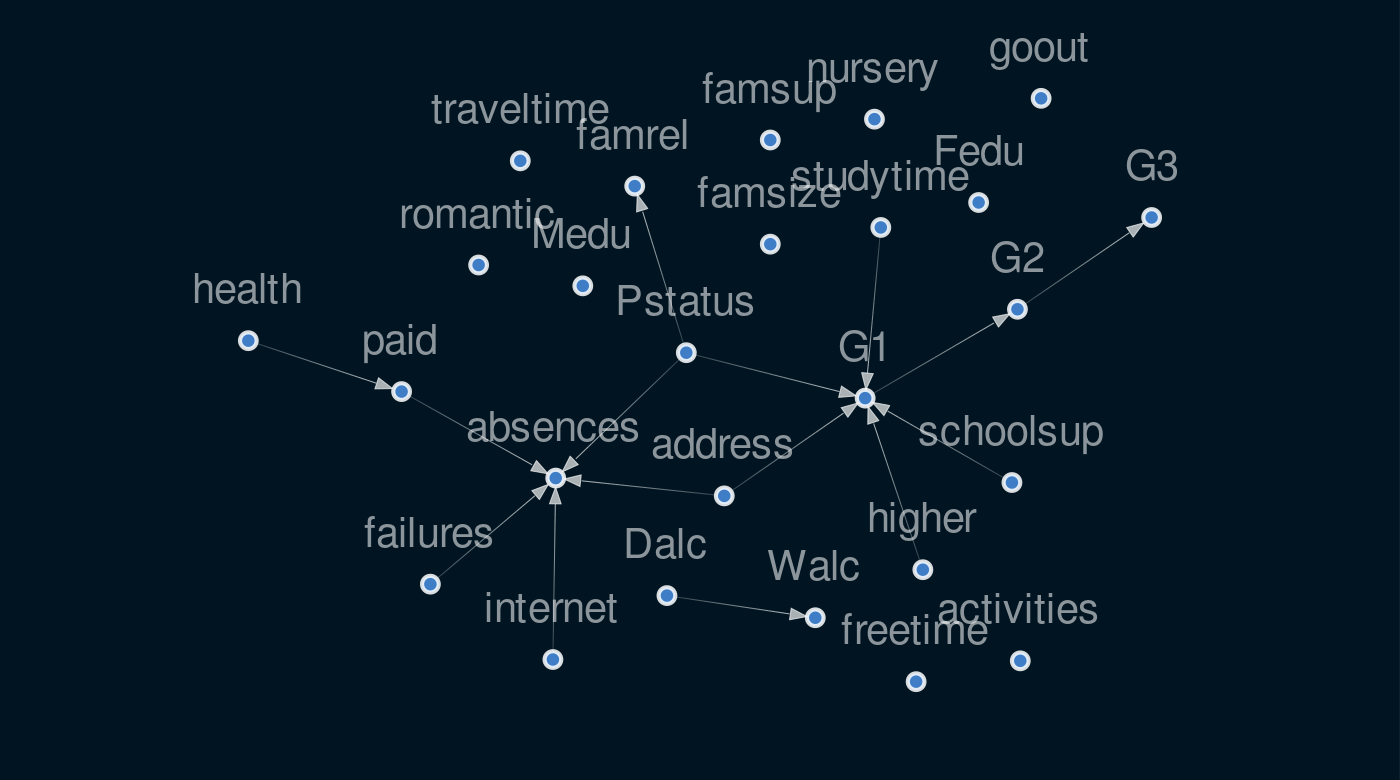

In [83]:
viz = plot_structure(
    structModeTestEdges,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_testEdges = curPath + "structureModel_testedges.png"
viz.draw(filename_testEdges)
Image(filename_testEdges)

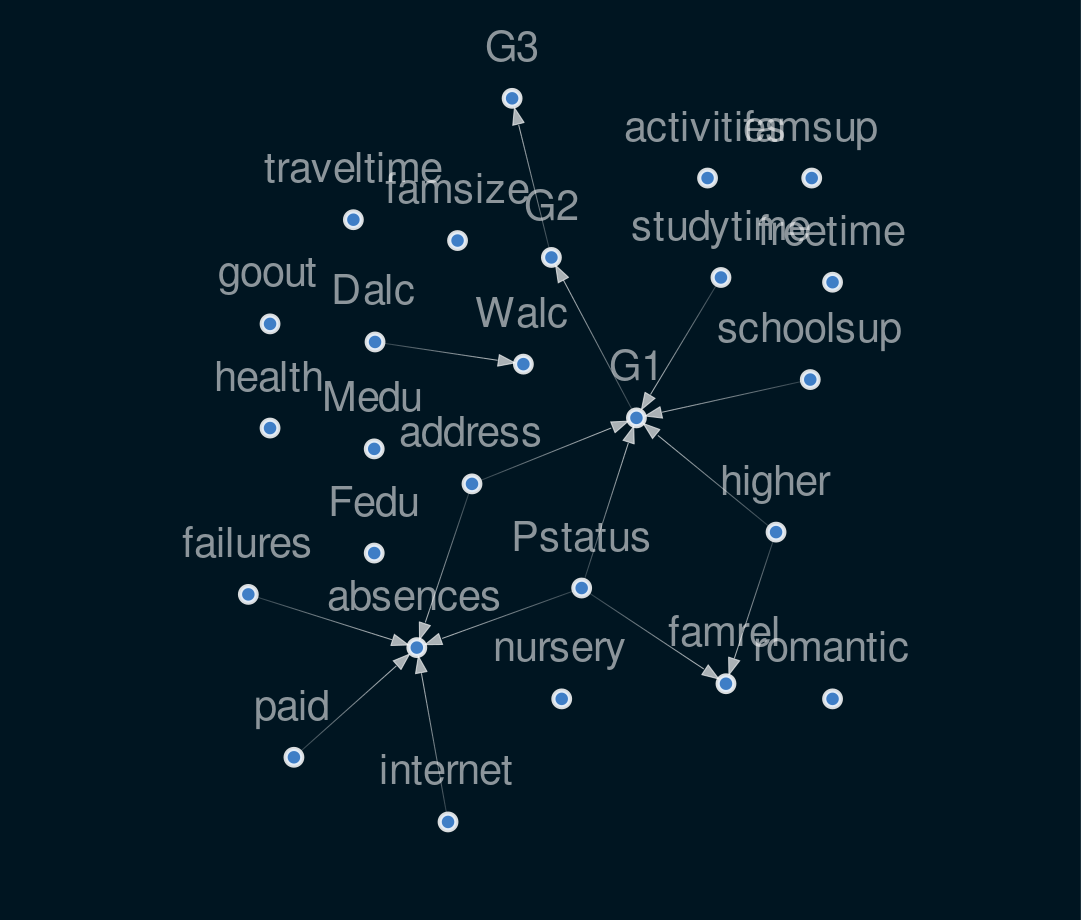

In [84]:
# Previous one:
Image(curPath + "structure_model_learnedStructure_noHigherMedu.png")

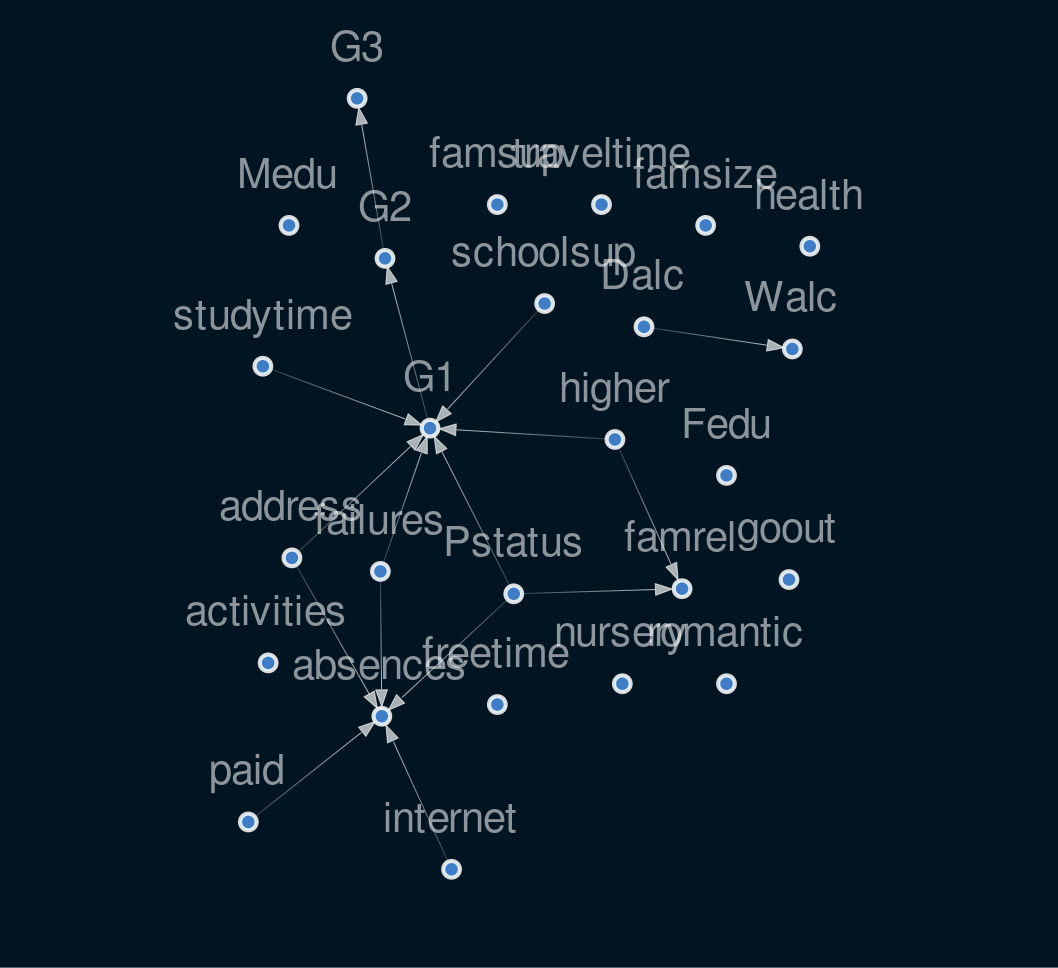

In [85]:
# Just doing same operations on the current graph, after tutorial:
structureModel.add_edge(u_of_edge = 'failures', v_of_edge = 'G1')
# structureModel.remove_edge(u = 'Pstatus', v = 'G1')
# structureModel.remove_edge(u = 'address', v='G1')

viz = plot_structure(
    structureModel,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_updateEdge = curPath + "structureModel_updated.png"
viz.draw(filename_updateEdge)
Image(filename_updateEdge)

Can see there are two separate subgraphs in the above plot: `Dalc -> Walc` and the other big subgraph. We can retrieve the largest subgraph easily by calling `get_largest_subgraph()`:

In [86]:
newStructModel: StructureModel = structureModel.get_largest_subgraph()

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'address', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'address', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


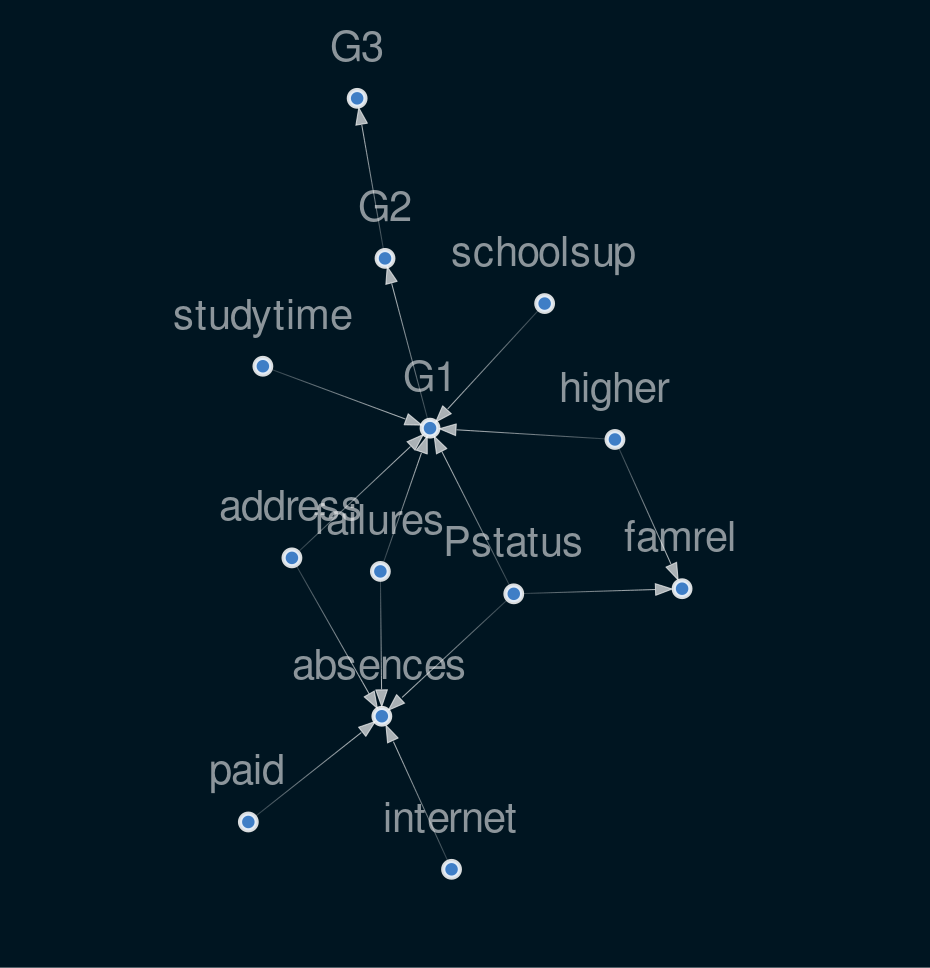

In [87]:
# Now visualize:
viz = plot_structure(
    newStructModel,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_finalStruct = curPath + "finalStruct.png"
viz.draw(filename_finalStruct)
Image(filename_finalStruct)

In [88]:
# Showing that within the same subgraph, we can query by two different nodes and get the same subgraph:
assert newStructModel.get_target_subgraph(node = 'G1').adj == newStructModel.get_target_subgraph(node = 'absences').adj

# NOTE key way how to find all unique subgraphs: going by nodes, for each node, if the current subgraph adjacency equals any other adjacency in the list, scrap that subgraph.

After deciding on how the final structure model should look, we can instantiate a `BayesianNetwork`:

In [89]:
from causalnex.network import BayesianNetwork

bayesNet: BayesianNetwork = BayesianNetwork(structure = newStructModel)
bayesNet.cpds

{}

In [90]:
bayesNet.edges
#bayesNet.node_states

[('address', 'absences'),
 ('address', 'G1'),
 ('G1', 'G2'),
 ('Pstatus', 'famrel'),
 ('Pstatus', 'absences'),
 ('Pstatus', 'G1'),
 ('studytime', 'G1'),
 ('failures', 'absences'),
 ('failures', 'G1'),
 ('schoolsup', 'G1'),
 ('paid', 'absences'),
 ('higher', 'famrel'),
 ('higher', 'G1'),
 ('internet', 'absences'),
 ('G2', 'G3')]

In [91]:
assert set(bayesNet.nodes) == set(list(iter(newStructModel.node)))
bayesNet.nodes

['address',
 'absences',
 'G1',
 'Pstatus',
 'famrel',
 'studytime',
 'failures',
 'schoolsup',
 'paid',
 'higher',
 'internet',
 'G2',
 'G3']

Can now learn the conditional probability distribution of different features in this `BayesianNetwork`

# 2/ Fitting the Conditional Distribution of the Bayesian Network
## Preparing the Discretised Data
Any continuous features should be discretised prior to fitting the Bayesian Network, since CausalNex networks support only discrete distributions.

Should make numerical features categorical by discretisation then give the buckets meaningful labels.
## 1. Reducing Cardinality of Categorical Features
To reduce cardinality of categorical features (reduce number of values they take on), can define a map `{oldValue: newValue}` and use this to update the feature we will discretise. Example: for the `studytime` feature, if the studytime is more than $2$ then categorize it as `long-studytime` and the rest of the values are binned under `short_studytime`.

In [92]:
discrData: DataFrame = data.copy()

# Getting unique values per variable
dataVals = {var: data[var].unique() for var in data.columns}
dataVals

{'address': array(['U', 'R'], dtype=object),
 'famsize': array(['GT3', 'LE3'], dtype=object),
 'Pstatus': array(['A', 'T'], dtype=object),
 'Medu': array([4, 1, 3, 2, 0]),
 'Fedu': array([4, 1, 2, 3, 0]),
 'traveltime': array([2, 1, 3, 4]),
 'studytime': array([2, 3, 1, 4]),
 'failures': array([0, 3, 1, 2]),
 'schoolsup': array(['yes', 'no'], dtype=object),
 'famsup': array(['no', 'yes'], dtype=object),
 'paid': array(['no', 'yes'], dtype=object),
 'activities': array(['no', 'yes'], dtype=object),
 'nursery': array(['yes', 'no'], dtype=object),
 'higher': array(['yes', 'no'], dtype=object),
 'internet': array(['no', 'yes'], dtype=object),
 'romantic': array(['no', 'yes'], dtype=object),
 'famrel': array([4, 5, 3, 1, 2]),
 'freetime': array([3, 2, 4, 1, 5]),
 'goout': array([4, 3, 2, 1, 5]),
 'Dalc': array([1, 2, 5, 3, 4]),
 'Walc': array([1, 3, 2, 4, 5]),
 'health': array([3, 5, 1, 2, 4]),
 'absences': array([ 4,  2,  6,  0, 10,  8, 16, 14,  1, 12, 24, 22, 32, 30, 21, 15,  9,
        1

In [93]:
failuresMap = {v: 'no_failure' if v == [0] else 'yes_failure'
               for v in dataVals['failures']} # 0, 1, 2, 3 (number of failures)
failuresMap

{0: 'no_failure', 3: 'yes_failure', 1: 'yes_failure', 2: 'yes_failure'}

In [94]:
studytimeMap = {v: 'short_studytime' if v in [1,2] else 'long_studytime'
                for v in dataVals['studytime']}
studytimeMap

{2: 'short_studytime',
 3: 'long_studytime',
 1: 'short_studytime',
 4: 'long_studytime'}

Once we have defined the maps `{oldValue: newValue}` we can update each feature, applying the map transformation. The `map` function applies the given dictionary as a rule to the called dictionary.

In [95]:
discrData['failures'] = discrData['failures'].map(failuresMap)
discrData['failures']

0       no_failure
1       no_failure
2       no_failure
3       no_failure
4       no_failure
          ...     
644    yes_failure
645     no_failure
646     no_failure
647     no_failure
648     no_failure
Name: failures, Length: 649, dtype: object

In [96]:
discrData['studytime'] = discrData['studytime'].map(studytimeMap)
discrData['studytime']

0      short_studytime
1      short_studytime
2      short_studytime
3       long_studytime
4      short_studytime
            ...       
644     long_studytime
645    short_studytime
646    short_studytime
647    short_studytime
648    short_studytime
Name: studytime, Length: 649, dtype: object

## 3. Discretising Numeric Features
To make numeric features categorical, they must first by discretised. The `causalnex.discretiser.Discretiser` helper class supports several discretisation methods.
Here, the `fixed` method will be applied, providing static values that define the bucket boundaries. For instance, `absences` will be discretised into buckets `< 1`, `1 to 9`, and `>= 10`. Each bucket will be labelled as an integer, starting from zero.

In [97]:
from causalnex.discretiser import Discretiser

# Many values in absences, G1, G2, G3
dataVals

{'address': array(['U', 'R'], dtype=object),
 'famsize': array(['GT3', 'LE3'], dtype=object),
 'Pstatus': array(['A', 'T'], dtype=object),
 'Medu': array([4, 1, 3, 2, 0]),
 'Fedu': array([4, 1, 2, 3, 0]),
 'traveltime': array([2, 1, 3, 4]),
 'studytime': array([2, 3, 1, 4]),
 'failures': array([0, 3, 1, 2]),
 'schoolsup': array(['yes', 'no'], dtype=object),
 'famsup': array(['no', 'yes'], dtype=object),
 'paid': array(['no', 'yes'], dtype=object),
 'activities': array(['no', 'yes'], dtype=object),
 'nursery': array(['yes', 'no'], dtype=object),
 'higher': array(['yes', 'no'], dtype=object),
 'internet': array(['no', 'yes'], dtype=object),
 'romantic': array(['no', 'yes'], dtype=object),
 'famrel': array([4, 5, 3, 1, 2]),
 'freetime': array([3, 2, 4, 1, 5]),
 'goout': array([4, 3, 2, 1, 5]),
 'Dalc': array([1, 2, 5, 3, 4]),
 'Walc': array([1, 3, 2, 4, 5]),
 'health': array([3, 5, 1, 2, 4]),
 'absences': array([ 4,  2,  6,  0, 10,  8, 16, 14,  1, 12, 24, 22, 32, 30, 21, 15,  9,
        1

In [98]:
discrData['absences'] = Discretiser(method = 'fixed', numeric_split_points = [1,10]).transform(data = data['absences'].values)

assert (np.unique(discrData['absences']) == np.array([0,1,2])).all()


discrData['G1'] = Discretiser(method = 'fixed', numeric_split_points = [10]).transform(data = data['G1'].values)
assert (np.unique(discrData['G1']) == np.array([0,1])).all()


discrData['G2'] = Discretiser(method = 'fixed', numeric_split_points = [10]).transform(data = data['G2'].values)
assert (np.unique(discrData['G2']) == np.array([0,1])).all()

discrData['G3'] = Discretiser(method = 'fixed', numeric_split_points = [10]).transform(data = data['G3'].values)
assert (np.unique(discrData['G3']) == np.array([0,1])).all()

## 4. Create Labels for Numeric Features
To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way we mapped category feature values.

In [99]:

absencesMap = {0: "No-absence", 1:"Low-absence", 2:"High-absence"}

G1Map = {0: "Fail", 1: "Pass"}
G2Map = {0: "Fail", 1: "Pass"}
G3Map = {0: "Fail", 1: "Pass"}

discrData['absences'] = discrData['absences'].map(absencesMap)
discrData['absences']

0      Low-absence
1      Low-absence
2      Low-absence
3       No-absence
4       No-absence
          ...     
644    Low-absence
645    Low-absence
646    Low-absence
647    Low-absence
648    Low-absence
Name: absences, Length: 649, dtype: object

In [100]:
discrData['G1'] = discrData['G1'].map(G1Map)
discrData['G1']

0      Fail
1      Fail
2      Pass
3      Pass
4      Pass
       ... 
644    Pass
645    Pass
646    Pass
647    Pass
648    Pass
Name: G1, Length: 649, dtype: object

In [101]:
discrData['G2'] = discrData['G2'].map(G2Map)
discrData['G2']

0      Pass
1      Pass
2      Pass
3      Pass
4      Pass
       ... 
644    Pass
645    Pass
646    Pass
647    Pass
648    Pass
Name: G2, Length: 649, dtype: object

In [102]:
discrData['G3'] = discrData['G3'].map(G3Map)
discrData['G3']




0      Pass
1      Pass
2      Pass
3      Pass
4      Pass
       ... 
644    Pass
645    Pass
646    Fail
647    Pass
648    Pass
Name: G3, Length: 649, dtype: object

In [103]:
# Now for reference later get the discrete data values also:
discrDataVals = {var: discrData[var].unique() for var in discrData.columns}
discrDataVals

{'address': array(['U', 'R'], dtype=object),
 'famsize': array(['GT3', 'LE3'], dtype=object),
 'Pstatus': array(['A', 'T'], dtype=object),
 'Medu': array([4, 1, 3, 2, 0]),
 'Fedu': array([4, 1, 2, 3, 0]),
 'traveltime': array([2, 1, 3, 4]),
 'studytime': array(['short_studytime', 'long_studytime'], dtype=object),
 'failures': array(['no_failure', 'yes_failure'], dtype=object),
 'schoolsup': array(['yes', 'no'], dtype=object),
 'famsup': array(['no', 'yes'], dtype=object),
 'paid': array(['no', 'yes'], dtype=object),
 'activities': array(['no', 'yes'], dtype=object),
 'nursery': array(['yes', 'no'], dtype=object),
 'higher': array(['yes', 'no'], dtype=object),
 'internet': array(['no', 'yes'], dtype=object),
 'romantic': array(['no', 'yes'], dtype=object),
 'famrel': array([4, 5, 3, 1, 2]),
 'freetime': array([3, 2, 4, 1, 5]),
 'goout': array([4, 3, 2, 1, 5]),
 'Dalc': array([1, 2, 5, 3, 4]),
 'Walc': array([1, 3, 2, 4, 5]),
 'health': array([3, 5, 1, 2, 4]),
 'absences': array(['Low-ab

## 5. Train / Test Split
Must train and test split data to help validate findings.
Split 90% train and 10% test.

In [104]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discrData,
                               train_size = 0.9, test_size = 0.10,
                               random_state = 7)

# 3/ Model Probability
With the learnt structure model and discretised data, we can now fit the probability distribution of the Bayesian Network.

**First Step:** The first step is to specify all the states that each node can take. Can be done from data or can provide dictionary of node values. Here, we use the full dataset to avoid cases where states in our test set do not exist in the training set. In the real world, those states would need to be provided using the dictionary method.

In [105]:
import copy


# First 'copying' the object so previous state is preserved:
# SOURCE: https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
bayesNetNodeStates = copy.deepcopy(bayesNet)
assert not bayesNetNodeStates == bayesNet, "Deepcopy bayesnet object must work"
# bayesNetNodeStates = BayesianNetwork(bayesNet.structure)

bayesNetNodeStates: BayesianNetwork = bayesNetNodeStates.fit_node_states(df = discrData)
bayesNetNodeStates.node_states

{'address': {'R', 'U'},
 'famsize': {'GT3', 'LE3'},
 'Pstatus': {'A', 'T'},
 'Medu': {0, 1, 2, 3, 4},
 'Fedu': {0, 1, 2, 3, 4},
 'traveltime': {1, 2, 3, 4},
 'studytime': {'long_studytime', 'short_studytime'},
 'failures': {'no_failure', 'yes_failure'},
 'schoolsup': {'no', 'yes'},
 'famsup': {'no', 'yes'},
 'paid': {'no', 'yes'},
 'activities': {'no', 'yes'},
 'nursery': {'no', 'yes'},
 'higher': {'no', 'yes'},
 'internet': {'no', 'yes'},
 'romantic': {'no', 'yes'},
 'famrel': {1, 2, 3, 4, 5},
 'freetime': {1, 2, 3, 4, 5},
 'goout': {1, 2, 3, 4, 5},
 'Dalc': {1, 2, 3, 4, 5},
 'Walc': {1, 2, 3, 4, 5},
 'health': {1, 2, 3, 4, 5},
 'absences': {'High-absence', 'Low-absence', 'No-absence'},
 'G1': {'Fail', 'Pass'},
 'G2': {'Fail', 'Pass'},
 'G3': {'Fail', 'Pass'}}

## Fit Conditional Probability Distributions
The `fit_cpds` method of `BayesianNetwork` accepts a dataset to learn the conditional probability distributions (CPDs) of **each node** along with a method of how to do this fit.

In [106]:
# Copying the object information
bayesNetCPD: BayesianNetwork = copy.deepcopy(bayesNetNodeStates)

# Fitting the CPDs
bayesNetCPD: BayesianNetwork = bayesNetCPD.fit_cpds(data = train,
                                                    method = "BayesianEstimator",
                                                    bayes_prior = "K2")

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/base.py:54: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  states = sorted(list(self.data.ix[:, variable].dropna().unique()))
/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimator

In [107]:
bayesNetCPD.cpds

{'address':                  
 address          
 R        0.302048
 U        0.697952,
 'absences': Pstatus               A                                                       \
 address               R                                                        
 failures     no_failure                      yes_failure                       
 internet             no        yes                    no                 yes   
 paid                 no   yes   no       yes          no       yes        no   
 absences                                                                       
 High-absence        0.2  0.25  0.2  0.333333         0.2  0.333333  0.333333   
 Low-absence         0.4  0.50  0.4  0.333333         0.4  0.333333  0.333333   
 No-absence          0.4  0.25  0.4  0.333333         0.4  0.333333  0.333333   
 
 Pstatus                                      ...           T                  \
 address                         U            ...           R               U   
 failur

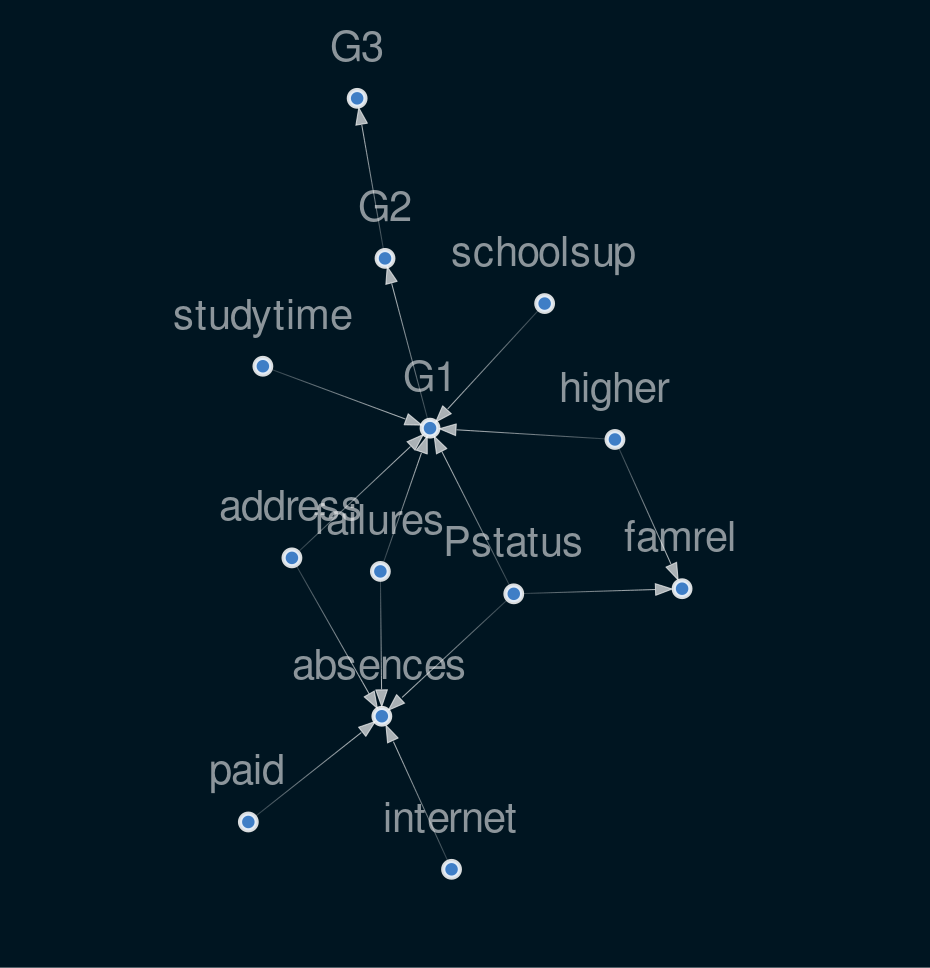

In [108]:
# The size of the tables depends on how many connections a node has
Image(filename_finalStruct)

In [109]:
# G1 has many connections so its table holds all the combinations of conditional probabilities.
bayesNetCPD.cpds['G1']

Pstatus                A                                                 \
address                R                                                  
failures      no_failure                                                  
higher                no                                                  
schoolsup             no                            yes                   
studytime long_studytime short_studytime long_studytime short_studytime   
G1                                                                        
Fail            0.666667        0.333333            0.5             0.5   
Pass            0.333333        0.666667            0.5             0.5   

Pstatus                                                                  \
address                                                                   
failures                                                                  
higher               yes                                                  
schoolsup             no                            yes                   
studytime long_studytime short_studytime long_studytime short_studytime   
G1                                                                        
Fail            0.333333        0.222222            0.5             0.5   
Pass            0.666667        0.777778            0.5             0.5   

Pstatus                                   ...              T                  \
address                                   ...              U                   
failures     yes_failure                  ...     no_failure                   
higher                no                  ...            yes                   
schoolsup             no                  ...            yes                   
studytime long_studytime short_studytime  ... long_studytime short_studytime   
G1                                        ...                                  
Fail            0.666667        0.666667  ...       0.222222        0.285714   
Pass            0.333333        0.333333  ...       0.777778        0.714286   

Pstatus                                                                  \
address                                                                   
failures     yes_failure                                                  
higher                no                                                  
schoolsup             no                            yes                   
studytime long_studytime short_studytime long_studytime short_studytime   
G1                                                                        
Fail            0.666667        0.789474            0.5        0.666667   
Pass            0.333333        0.210526            0.5        0.333333   

Pstatus                                                                  
address                                                                  
failures                                                                 
higher               yes                                                 
schoolsup             no                            yes                  
studytime long_studytime short_studytime long_studytime short_studytime  
G1                                                                       
Fail            0.571429        0.652174            0.5        0.666667  
Pass            0.428571        0.347826            0.5        0.333333  

[2 rows x 64 columns]

In [110]:
bayesNetCPD.cpds['absences']

Pstatus               A                                                       \
address               R                                                        
failures     no_failure                      yes_failure                       
internet             no        yes                    no                 yes   
paid                 no   yes   no       yes          no       yes        no   
absences                                                                       
High-absence        0.2  0.25  0.2  0.333333         0.2  0.333333  0.333333   
Low-absence         0.4  0.50  0.4  0.333333         0.4  0.333333  0.333333   
No-absence          0.4  0.25  0.4  0.333333         0.4  0.333333  0.333333   

Pstatus                                      ...           T                  \
address                         U            ...           R               U   
failures               no_failure            ... yes_failure      no_failure   
internet                       no            ...         yes              no   
paid               yes         no       yes  ...          no  yes         no   
absences                                     ...                               
High-absence  0.333333   0.200000  0.333333  ...    0.148148  0.2   0.061224   
Low-absence   0.333333   0.666667  0.333333  ...    0.518519  0.6   0.612245   
No-absence    0.333333   0.133333  0.333333  ...    0.333333  0.2   0.326531   

Pstatus                                                                       
address                                                                       
failures                               yes_failure                            
internet                 yes                    no             yes            
paid           yes        no       yes          no   yes        no       yes  
absences                                                                      
High-absence  0.25  0.109312  0.071429    0.142857  0.25  0.323529  0.222222  
Low-absence   0.25  0.473684  0.714286    0.428571  0.25  0.470588  0.555556  
No-absence    0.50  0.417004  0.214286    0.428571  0.50  0.205882  0.222222  

[3 rows x 32 columns]

In [111]:
# Studytime variable is a singular ndoe so its table is small, no conditional probabilities here.
bayesNetCPD.cpds['studytime']

,
studytime,
long_studytime,0.204778
short_studytime,0.795222


In [112]:
# Pstatus has only outgoing nodes, no incoming nodes so has no conditional probabilities.
bayesNetCPD.cpds['Pstatus']

,
Pstatus,
A,0.119454
T,0.880546


In [113]:
# Famrel has two incoming nodes (PStatus and higher) so models their conditional probabilities.
bayesNetCPD.cpds['famrel']

Pstatus         A                   T          
higher         no       yes        no       yes
famrel                                         
1        0.142857  0.061538  0.064516  0.023758
2        0.142857  0.092308  0.048387  0.045356
3        0.285714  0.092308  0.161290  0.159827
4        0.357143  0.461538  0.419355  0.503240
5        0.071429  0.292308  0.306452  0.267819

In [114]:
bayesNetCPD.cpds['G2']

G1,Fail,Pass
G2,,
Fail,0.5,0.5
Pass,0.5,0.5


In [115]:
bayesNetCPD.cpds['G3']

G2,Fail,Pass
G3,,
Fail,0.5,0.5
Pass,0.5,0.5


The CPD dictionaries are multiindexed so the `loc` functino can be a useful way to interact with them:

In [116]:
# TODO: https://hyp.is/_95epIOuEeq_HdeYjzCPXQ/causalnex.readthedocs.io/en/latest/03_tutorial/03_tutorial.html
discrData.loc[1:5,['address', 'G1', 'paid', 'higher']]



,address,G1,paid,higher
1,U,Fail,no,yes
2,U,Pass,no,yes
3,U,Pass,no,yes
4,U,Pass,no,yes
5,U,Pass,no,yes


## Predict the State given the Input Data
The `predict` method of `BayesianNetwork` allos us to make predictions based on the data using the learnt network. For example we want to predict if a student passes of failes the exam based on the input data. Consider an incoming student data like this:

In [117]:
# Row number 18
discrData.loc[18, discrData.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short_studytime
failures          yes_failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          Low-absence
G2                       Fail
G3                       Fail
Name: 18, dtype: object

Based on this data, want to predict if this particular student (in row 18) will succeed on their exam. Intuitively expect this student not to succeed because they spend shorter amount of study time and have failed in the past.

There are two kinds of prediction methods:
* [`predict_probability(data, node)`](https://causalnex.readthedocs.io/en/latest/source/api_docs/causalnex.network.BayesianNetwork.html#causalnex.network.BayesianNetwork.predict_probability): Predict the **probability of each possible state of a node**, based on some input data.
* [`predict(data, node)`](https://causalnex.readthedocs.io/en/latest/source/api_docs/causalnex.network.BayesianNetwork.html#causalnex.network.BayesianNetwork.predict): Predict the **state of a node ** based on some input data, using the Bayesian Network.

In [118]:
predictionProbs = bayesNetCPD.predict_probability(data = discrData, node = 'G1')
predictionProbs

,G1_Pass,G1_Fail
0,0.777778,0.222222
1,0.882051,0.117949
2,0.714286,0.285714
3,0.968254,0.031746
4,0.882051,0.117949
...,...,...
644,0.600000,0.400000
645,0.882051,0.117949
646,0.882051,0.117949
647,0.882051,0.117949


In [119]:
# Student 18 passes with probability 0.358, and fails with prob 0.64
predictionProbs.loc[18, :]

G1_Pass    0.347826
G1_Fail    0.652174
Name: 18, dtype: float64

In [120]:
# This function does predictions for ALL observations (all students)
predictions = bayesNetCPD.predict(data = discrData, node = 'G1')
predictions

,G1_prediction
0,Pass
1,Pass
2,Pass
3,Pass
4,Pass
...,...
644,Pass
645,Pass
646,Pass
647,Pass


In [121]:
predictions.loc[18, :]

G1_prediction    Fail
Name: 18, dtype: object

Compare this prediction to the ground truth:

In [122]:
print(f"Student 18 is predicted to {predictions.loc[18, 'G1_prediction']}")
print(f"Ground truth for student 18 is {discrData.loc[18, 'G1']}")

Student 18 is predicted to Fail
Ground truth for student 18 is Fail


# 4/ Model Quality
To evaluate the quality of the model that has been learned, CausalNex supports two main approaches: Classification Report and Reciever Operating Characteristics (ROC) / Area Under the ROC Curve (AUC).
## Measure 1: Classification Report
To obtain a classification report using a BN, we need to provide a test set and the node we are trying to classify. The classification report predicts the target node for all rows (observations) in the test set and evaluate how well those predictions are made, via the model.

In [123]:
from causalnex.evaluation import classification_report

classification_report(bn = bayesNetCPD, data = test, node = 'G1')

,precision,recall,f1-score,support
G1_Fail,0.777778,0.583333,0.666667,12
G1_Pass,0.910714,0.962264,0.935780,53
micro avg,0.892308,0.892308,0.892308,65
macro avg,0.844246,0.772799,0.801223,65
weighted avg,0.886172,0.892308,0.886097,65


**Interpret Results of classification report:** this report shows that the model can classify reasonably well whether a student passs the exam. For predictions where the student fails, the precision is adequate but recall is bad. This implies that we can rely on predictions for `G1_Fail` but we are likely to miss some of the predictions we should have made. Perhaps these missing predictions are a result of something missing in our structure
* ALERT - explore graph structure when the recall is bad


## ROC / AUC
The ROC and AUC can be obtained with `roc_auc` method within CausalNex metrics module.
ROC curve is computed by micro-averaging predictions made across all states (classes) of the target node.

In [124]:
from causalnex.evaluation import roc_auc

roc, auc = roc_auc(bn = bayesNetCPD, data = test, node = 'G1')

print(f"ROC = \n{roc}\n")
print(f"AUC = {auc}")

ROC = 
[(0.0, 0.0), (0.0, 0.1076923076923077), (0.0, 0.16923076923076924), (0.046153846153846156, 0.5076923076923077), (0.046153846153846156, 0.5692307692307692), (0.046153846153846156, 0.6), (0.06153846153846154, 0.6153846153846154), (0.09230769230769231, 0.7692307692307693), (0.09230769230769231, 0.8), (0.1076923076923077, 0.8), (0.1076923076923077, 0.8461538461538461), (0.15384615384615385, 0.8923076923076924), (0.2, 0.8923076923076924), (0.2, 0.9076923076923077), (0.23076923076923078, 0.9076923076923077), (0.38461538461538464, 0.9384615384615385), (0.4, 0.9538461538461539), (0.4307692307692308, 0.9538461538461539), (0.49230769230769234, 0.9538461538461539), (0.8307692307692308, 1.0), (0.8923076923076924, 1.0), (1.0, 1.0)]

AUC = 0.9123076923076924


High value of AUC gives confidence in model performance



# 5/ Querying Marginals
After iterating over our model structure, CPDs, and validating our model quality, we can **query our model under different observations** to gain insights.

## Baseline Marginals
To query the model for baseline marginals that reflect the population as a whole, a `query` method can be used.

**First:** update the model using the complete dataset since the one we currently have is built only from training data.

In [125]:
# Copy object:
bayesNetFull = copy.deepcopy(bayesNetCPD)

# Fitting CPDs with full data
bayesNetFull: BayesianNetwork = bayesNetFull.fit_cpds(data = discrData,
                                                     method = "BayesianEstimator",
                                                     bayes_prior = "K2")

Get warnings, showing we are replacing the previously existing CPDs

**Second**: For inference, must create a new `InferenceEngine` from our `BayesianNetwork`, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes. Query lets us get the marginal distributions, marginalizing to get rid of the conditioning variable(s) for each node variable.

In [126]:
from causalnex.inference import InferenceEngine


eng = InferenceEngine(bn = bayesNetFull)
eng

Query the baseline marginal distributions, which means querying marginals **as learned from data**:

In [127]:
marginalDistLearned: Dict[str, Dict[str, float]] = eng.query()
marginalDistLearned

{'address': {'R': 0.3041474654377881, 'U': 0.6958525345622117},
 'absences': {'High-absence': 0.1278149471852898,
  'Low-absence': 0.5034849294152204,
  'No-absence': 0.36870012339948993},
 'G1': {'Fail': 0.2614871976647877, 'Pass': 0.7385128023352121},
 'Pstatus': {'A': 0.12442396313364057, 'T': 0.8755760368663592},
 'famrel': {1: 0.03724247501855778,
  2: 0.04846203869543736,
  3: 0.15602529390568748,
  4: 0.4814761637760789,
  5: 0.2767940286042384},
 'studytime': {'long_studytime': 0.20430107526881724,
  'short_studytime': 0.7956989247311828},
 'failures': {'no_failure': 0.8448540706605223,
  'yes_failure': 0.1551459293394777},
 'schoolsup': {'no': 0.8940092165898619, 'yes': 0.10599078341013828},
 'paid': {'no': 0.9385560675883257, 'yes': 0.06144393241167435},
 'higher': {'no': 0.10752688172043012, 'yes': 0.8924731182795699},
 'internet': {'no': 0.2334869431643625, 'yes': 0.7665130568356374},
 'G2': {'Fail': 0.4999999999999999, 'Pass': 0.4999999999999999},
 'G3': {'Fail': 0.4999999

In [128]:
marginalDistLearned['address']

{'R': 0.3041474654377881, 'U': 0.6958525345622117}

In [129]:
marginalDistLearned['G1']

{'Fail': 0.2614871976647877, 'Pass': 0.7385128023352121}

Output tells us that `P(G1=Fail) ~ 0.25` and `P(G1 = Pass) ~ 0.75`. As a quick sanity check can compute what proportion of our data are `Fail` and `Pass`, should give nearly the same result:

In [130]:
import numpy as np

labels, counts = np.unique(discrData['G1'], return_counts = True)

print(list(zip(labels, counts)))
print('\nProportion failures = {}'.format(counts[0] / sum(counts)))
print('\nProportion passes = {}'.format(counts[1] / sum(counts)))

[('Fail', 157), ('Pass', 492)]

Proportion failures = 0.24191063174114022

Proportion passes = 0.7580893682588598


## Marginals After Observations
Can query the marginal likelihood of states in our network, **given observations**.

$\color{red}{\text{TODO}}$ is this using the Bayesian update rule?

These observations can be made anywhere in the network and their impact will be propagated through to the node of interest.

In [131]:
# Reminding of the data types for each variable:
discrDataVals

{'address': array(['U', 'R'], dtype=object),
 'famsize': array(['GT3', 'LE3'], dtype=object),
 'Pstatus': array(['A', 'T'], dtype=object),
 'Medu': array([4, 1, 3, 2, 0]),
 'Fedu': array([4, 1, 2, 3, 0]),
 'traveltime': array([2, 1, 3, 4]),
 'studytime': array(['short_studytime', 'long_studytime'], dtype=object),
 'failures': array(['no_failure', 'yes_failure'], dtype=object),
 'schoolsup': array(['yes', 'no'], dtype=object),
 'famsup': array(['no', 'yes'], dtype=object),
 'paid': array(['no', 'yes'], dtype=object),
 'activities': array(['no', 'yes'], dtype=object),
 'nursery': array(['yes', 'no'], dtype=object),
 'higher': array(['yes', 'no'], dtype=object),
 'internet': array(['no', 'yes'], dtype=object),
 'romantic': array(['no', 'yes'], dtype=object),
 'famrel': array([4, 5, 3, 1, 2]),
 'freetime': array([3, 2, 4, 1, 5]),
 'goout': array([4, 3, 2, 1, 5]),
 'Dalc': array([1, 2, 5, 3, 4]),
 'Walc': array([1, 3, 2, 4, 5]),
 'health': array([3, 5, 1, 2, 4]),
 'absences': array(['Low-ab

In [132]:
# Reminder of nodes you CAN query (for instance putting 'health' in the dictionary argument of 'query' will give us an error)
bayesNetFull.nodes

['address',
 'absences',
 'G1',
 'Pstatus',
 'famrel',
 'studytime',
 'failures',
 'schoolsup',
 'paid',
 'higher',
 'internet',
 'G2',
 'G3']

In [133]:
marginalDistObs_biasPass: Dict[str, Dict[str, float]] = eng.query({'studytime': 'long_studytime', 'paid':'yes', 'higher':'yes', 'absences':'No-absence', 'failures':'no_failure'})

# Seeing if biasing in favor of failing will influence the observed marginals:
marginalDistObs_biasFail: Dict[str, Dict[str, float]] = eng.query({'studytime': 'short_studytime', 'paid':'no', 'higher':'no', 'absences':'High-absence', 'failures': 'yes_failure'})

In [134]:
# Higher probability of passing when have the above observations, since they are another set of observations in favor of passing.
marginalDistLearned['G1']

{'Fail': 0.2614871976647877, 'Pass': 0.7385128023352121}

In [135]:
marginalDistObs_biasPass['G1']

{'Fail': 0.07373430443712227, 'Pass': 0.9262656955628777}

In [136]:
marginalDistObs_biasFail['G1']

{'Fail': 0.7243863093775379, 'Pass': 0.27561369062246216}

In [137]:
marginalDistLearned['G2']

{'Fail': 0.4999999999999999, 'Pass': 0.4999999999999999}

In [138]:
# G2 and G3 nodes don't show bias probability because they are not many conditionals on them.
marginalDistObs_biasPass['G2']

{'Fail': 0.5, 'Pass': 0.5}

In [139]:
marginalDistObs_biasFail['G2']

{'Fail': 0.5, 'Pass': 0.5}

In [140]:
marginalDistLearned['G3']

{'Fail': 0.4999999999999999, 'Pass': 0.4999999999999999}

In [141]:
marginalDistObs_biasPass['G3']

{'Fail': 0.5, 'Pass': 0.5}

In [142]:
marginalDistObs_biasFail['G3']

{'Fail': 0.5, 'Pass': 0.5}

Looking at difference in likelihood of `G1` based on just `studytime`. See that students who study longer are more likely to pass on their exam:

In [143]:
marginalDist_short = eng.query({'studytime':'short_studytime'})
marginalDist_long = eng.query({'studytime': 'long_studytime'})

print('Marginal G1 | Short Studytime', marginalDist_short['G1'])
print('Marginal G1 | Long Studytime', marginalDist_long['G1'])

Marginal G1 | Short Studytime {'Fail': 0.2817997392562336, 'Pass': 0.7182002607437664}
Marginal G1 | Long Studytime {'Fail': 0.18237519357178764, 'Pass': 0.8176248064282124}


## Interventions with Do Calculus
Do-Calculus, allows us to specify interventions.

### Updating a Node Distribution
Can apply an intervention to any node in our data, updating its distribution using a `do` operator, which means asking our mdoel "what if" something were different.

For example, can ask what would happen if 100% of students wanted to go on to do higher education.

In [144]:
print("'higher' marginal distribution before DO: ", eng.query()['higher'])

# Make the intervention on the network
eng.do_intervention(node = 'higher', state = {'yes': 1.0, 'no': 0.0}) # all students yes

print("'higher' marginal distribution after DO: ", eng.query()['higher'])

'higher' marginal distribution before DO:  {'no': 0.10752688172043012, 'yes': 0.8924731182795699}


'higher' marginal distribution after DO:  {'no': 0.0, 'yes': 1.0000000000000002}


### Resetting a Node Distribution
We can reset any interventions that we make using `reset_intervention` method and providing the node we want to reset:

In [145]:
eng.reset_do('higher')

eng.query()['higher'] # same as before

{'no': 0.10752688172043012, 'yes': 0.8924731182795699}

### Effect of DO on Marginals
We can use `query` to find the effect that an intervention has on our marginal likelihoods of OTHER variables, not just on the INTERVENED variable.

**Example 1:** change 'higher' and check grade 'G1' (how the likelihood of achieving a pass changes if 100% of students wanted to do higher education)

Answer: if 100% of students wanted to do higher education (as opposed to 90% in our data population) , then we estimate the pass rate would increase from 74.7% to 79.3%.

In [146]:
print('marginal G1', eng.query()['G1'])

eng.do_intervention(node = 'higher', state = {'yes':1.0, 'no': 0.0})
print('updated marginal G1', eng.query()['G1'])

marginal G1 {'Fail': 0.2614871976647877, 'Pass': 0.7385128023352121}


updated marginal G1 {'Fail': 0.22096538189680157, 'Pass': 0.7790346181031987}


In [147]:
# This is how we know it is 90% of the population that does higher education:
eng.reset_do('higher')

eng.query()['higher']

{'no': 0.10752688172043012, 'yes': 0.8924731182795699}

In [148]:
# OR:
labels, counts = np.unique(discrData['higher'], return_counts = True)
counts / sum(counts)

array([0.10631741, 0.89368259])

**Example 2:** change 'higher' and check grade 'G1' (how the likelihood of achieving a pass changes if 80% of students wanted to do higher education)

In [149]:
eng.reset_do('higher')

print('marginal G1', eng.query()['G1'])

eng.do_intervention(node = 'higher', state = {'yes':0.8, 'no': 0.2})
print('updated marginal G1', eng.query()['G1']) # fail is actually higher!!!!

marginal G1 {'Fail': 0.2614871976647877, 'Pass': 0.7385128023352121}


updated marginal G1 {'Fail': 0.2963359592252558, 'Pass': 0.7036640407747445}
